/tmp/ipykernel_187/1064077253.py:32: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(IM_SIZE, IM_SIZE, border_mode=cv2.BORDER_CONSTANT, value=(0,0,0)),


test_apple: V1=healthy_strawberry(5.1%) | V6=apple_apple_scab(91.8%)
test_grape: V1=pumpkin_powdery_mildew(3.0%) | V6=corn_northern_leaf_blight(10.8%)


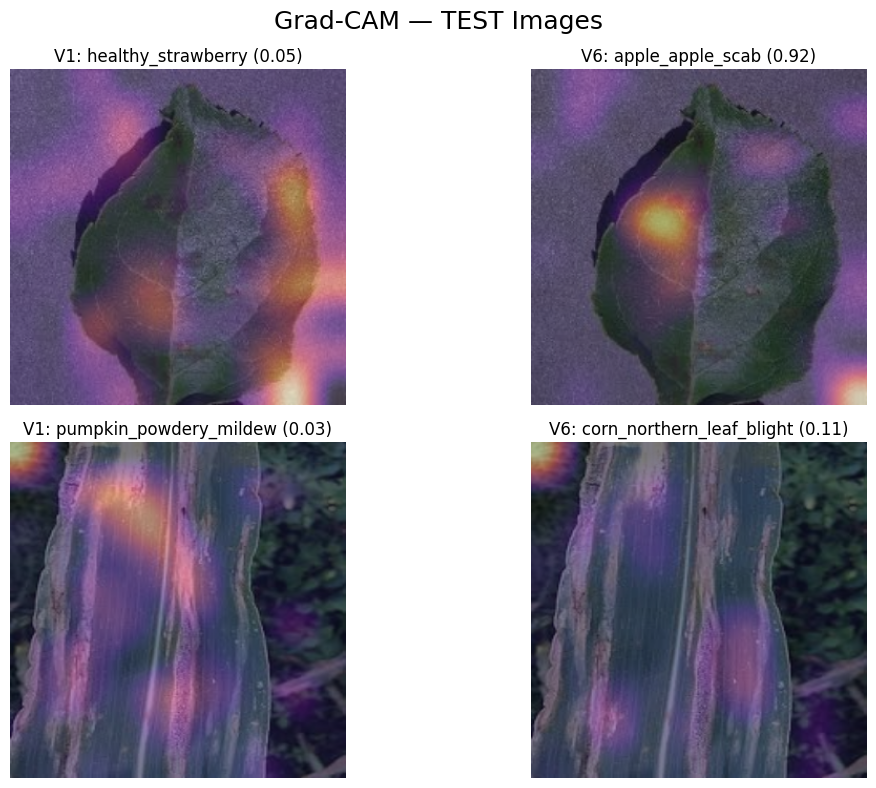

✅ Saved: gradcam_test.png
train_apple: V1=groundnut_late_leaf_spot(4.3%) | V6=tomato_early_blight(7.7%)
train_tomato: V1=groundnut_late_leaf_spot(4.4%) | V6=apple_cedar_apple_rust(8.5%)


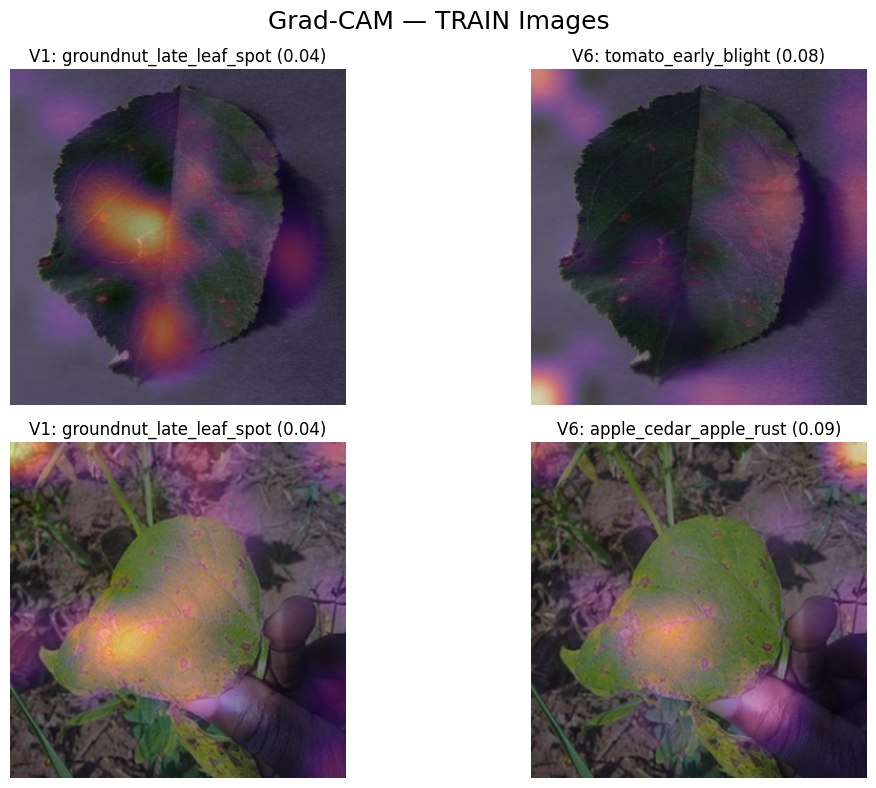

✅ Saved: gradcam_train.png


In [29]:
# ===========================
# GRAD-CAM: V1 vs V6 Comparison (Final Clean)
# ===========================
import torch, torch.nn.functional as F
import numpy as np, cv2, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from torchcam.methods import GradCAM
import timm

CKPT_V1 = "/kaggle/input/cnn-v1/effb3_320_std_domain.pt"
CKPT_V6 = "/kaggle/input/v6-model/effb3_320_curated_hardened_v6.pt"

paths = {
    "test_apple": "/kaggle/input/plant-disease-google-test-images/test_google/test/apple_apple_scab/download (1).jpg",
    "test_grape": "/kaggle/input/plant-disease-google-test-images/test_google/test/corn_northern_leaf_blight/download (1).jpg",
    "train_apple": "/kaggle/input/plant-disease-detection-dataset-master-version/MasterDataset/train/apple_cedar_apple_rust/00bf5184-847d-5246-8e70-2444d3b10e13.jpg",
    "train_tomato": "/kaggle/input/plant-disease-detection-dataset-master-version/MasterDataset/train/bean_angular_leaf_spot/0995977c-0f0c-5718-8786-8639124eada5.jpg"
}

IM_SIZE = 320
IM_MEAN = [0.485, 0.456, 0.406]
IM_STD = [0.229, 0.224, 0.225]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_val_transform():
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    return A.Compose([
        A.LongestMaxSize(max_size=IM_SIZE),
        A.PadIfNeeded(IM_SIZE, IM_SIZE, border_mode=cv2.BORDER_CONSTANT, value=(0,0,0)),
        A.CenterCrop(IM_SIZE, IM_SIZE),
        A.Normalize(mean=IM_MEAN, std=IM_STD),
        ToTensorV2(),
    ])

tf_val = get_val_transform()


def load_effb3_from_ckpt(ckpt_path, num_classes, drop_head=False):
    model = timm.create_model("efficientnet_b3", pretrained=False, num_classes=num_classes)
    state = torch.load(ckpt_path, map_location="cpu")
    sd = state.get("model", state)
    if drop_head:
        sd = {k: v for k, v in sd.items() if not k.startswith("classifier.")}
    model.load_state_dict(sd, strict=False)
    return model.to(DEVICE).eval()


state_v6 = torch.load(CKPT_V6, map_location="cpu")
label2idx_v6 = state_v6.get("label2idx", None)
num_classes_v6 = len(label2idx_v6) if label2idx_v6 else 53
idx2label_v6 = {v: k for k, v in label2idx_v6.items()} if label2idx_v6 else {}

model_v1 = load_effb3_from_ckpt(CKPT_V1, num_classes_v6, drop_head=True)
model_v6 = load_effb3_from_ckpt(CKPT_V6, num_classes_v6, drop_head=False)

for p in model_v1.parameters():
    p.requires_grad = True


def predict_top(model, img_bgr):
    x = tf_val(image=img_bgr)["image"].unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1)[0].cpu().numpy()
    idx = int(np.argmax(probs))
    return idx, probs[idx]


def remove_cam_hooks(model):
    for m in model.modules():
        if hasattr(m, "_forward_hooks"): m._forward_hooks.clear()
        if hasattr(m, "_forward_pre_hooks"): m._forward_pre_hooks.clear()
        if hasattr(m, "_backward_hooks"): m._backward_hooks.clear()


def gradcam_for_image(model, img_bgr, target_idx):
    x = tf_val(image=img_bgr)["image"].unsqueeze(0).to(DEVICE)

    # closer to classifier (better localization)
    cam_extractor = GradCAM(model, target_layer="conv_head")

    model.zero_grad(set_to_none=True)
    with torch.enable_grad():
        model.train()
        logits = model(x)

    cams = cam_extractor(class_idx=target_idx, scores=logits)
    cam = cams[0].detach().cpu().numpy()

    # (C, H, W) or (1, H, W) -> (H, W)
    if cam.ndim == 3:
        cam = cam.mean(axis=0)

    # upscale carefully
    cam = cv2.resize(cam, (IM_SIZE, IM_SIZE), interpolation=cv2.INTER_CUBIC)

    # normalize
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    # stronger smoothing helps with tiny feature maps
    cam = cv2.GaussianBlur(cam, (15, 15), 0)

    heatmap = (plt.cm.magma(cam)[:, :, :3] * 255).astype(np.uint8)

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_rgb = cv2.resize(img_rgb, (IM_SIZE, IM_SIZE))

    overlay = (0.55 * heatmap + 0.45 * img_rgb).astype(np.uint8)
    overlay = Image.fromarray(overlay)

    remove_cam_hooks(model)
    return overlay



def build_figure(subset_keys, save_name, title):
    n = len(subset_keys)
    fig, axes = plt.subplots(n, 2, figsize=(12, 4*n))

    if n == 1:
        axes = np.array([axes])   # ensure iterable rows

    for i, key in enumerate(subset_keys):
        img_bgr = cv2.imread(paths[key])

        # ---- V1 ----
        idx_v1, conf_v1 = predict_top(model_v1, img_bgr)
        cls_v1 = idx2label_v6.get(idx_v1, f"class_{idx_v1}")
        overlay_v1 = gradcam_for_image(model_v1, img_bgr, idx_v1)

        axes[i, 0].imshow(overlay_v1)
        axes[i, 0].set_title(f"V1: {cls_v1} ({conf_v1:.2f})")
        axes[i, 0].axis("off")

        # ---- V6 ----
        idx_v6, conf_v6 = predict_top(model_v6, img_bgr)
        cls_v6 = idx2label_v6.get(idx_v6, f"class_{idx_v6}")
        overlay_v6 = gradcam_for_image(model_v6, img_bgr, idx_v6)

        axes[i, 1].imshow(overlay_v6)
        axes[i, 1].set_title(f"V6: {cls_v6} ({conf_v6:.2f})")
        axes[i, 1].axis("off")

        print(f"{key}: V1={cls_v1}({conf_v1:.1%}) | V6={cls_v6}({conf_v6:.1%})")

    plt.suptitle(title, fontsize=18)
    plt.tight_layout()
    plt.savefig(save_name, dpi=220, bbox_inches="tight")
    plt.show()
    print(f"✅ Saved: {save_name}")


# ---- build two clean figures ----
test_keys  = [k for k in paths if k.startswith("test_")]
train_keys = [k for k in paths if k.startswith("train_")]

build_figure(test_keys,  "gradcam_test.png",  "Grad-CAM — TEST Images")
build_figure(train_keys, "gradcam_train.png", "Grad-CAM — TRAIN Images")



In [43]:
import json

LABEL_JSON = "/kaggle/input/k/adiithape/cnn-model-v3/outputs/metadata/label2idx_v6.json"

with open(LABEL_JSON, "r") as f:
    label2idx = json.load(f)

idx2label = {v: k for k, v in label2idx.items()}


In [44]:
from glob import glob
import os

def load_dataset(root_dir):
    items = []
    for cls_name in os.listdir(root_dir):
        d = os.path.join(root_dir, cls_name)
        if not os.path.isdir(d):
            continue
        
        if cls_name not in label2idx:
            continue   # skip unknown classes
        
        cls_idx = label2idx[cls_name]
        for p in glob(os.path.join(d, "*")):
            items.append((p, cls_idx))
    return items


In [45]:
def gather_probs(model, items):
    probs_all, correct_all = [], []

    for img_path, true_idx in items:
        img_bgr = cv2.imread(img_path)
        if img_bgr is None:
            continue
        
        pred_idx, conf = predict_top(model, img_bgr)

        probs_all.append(conf)
        correct_all.append(int(pred_idx == true_idx))

    return np.array(probs_all), np.array(correct_all)


In [46]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

def plot_calibration(probs, correct, label, color):
    frac_pos, mean_pred = calibration_curve(correct, probs, n_bins=10)
    plt.plot(mean_pred, frac_pos, marker="o", label=label, color=color)
    plt.plot([0,1],[0,1],"--",color="gray")

    brier = brier_score_loss(correct, probs)
    print(f"{label} Brier score: {brier:.4f}")


In [ ]:
MASTER_VAL_DIR  = "/kaggle/input/plant-disease-detection-dataset-master-version/MasterDataset/test"  
GOOGLE_TEST_DIR = "/kaggle/input/plant-disease-google-test-images/test_google/test"


V1 (Master) Brier score: 0.0170
V6 (Master) Brier score: 0.1924


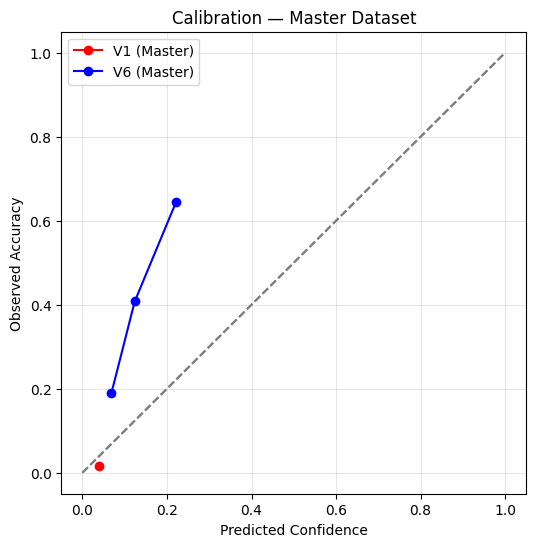

V1 (Google) Brier score: 0.0214
V6 (Google) Brier score: 0.0816


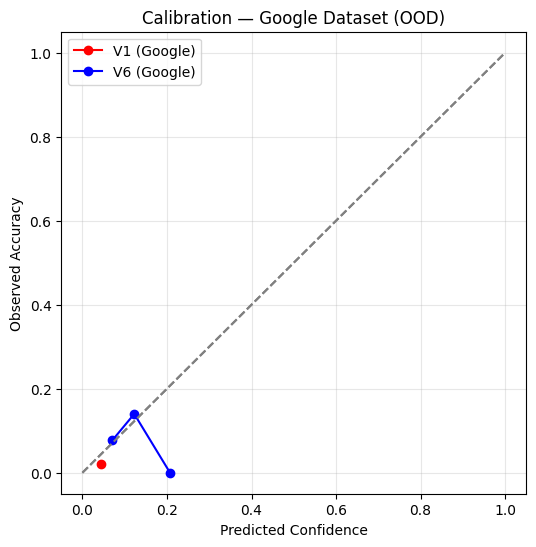

In [48]:
# -------- MASTER DATASET --------
master_items = load_dataset(MASTER_VAL_DIR)

probs_v1, corr_v1 = gather_probs(model_v1, master_items)
probs_v6, corr_v6 = gather_probs(model_v6, master_items)

plt.figure(figsize=(6,6))
plot_calibration(probs_v1, corr_v1, "V1 (Master)", "red")
plot_calibration(probs_v6, corr_v6, "V6 (Master)", "blue")
plt.title("Calibration — Master Dataset")
plt.xlabel("Predicted Confidence")
plt.ylabel("Observed Accuracy")
plt.legend(); plt.grid(alpha=0.3)
plt.savefig("calibration_master.png", dpi=200, bbox_inches="tight")
plt.show()


# -------- GOOGLE 200 IMAGES --------
google_items = load_dataset(GOOGLE_TEST_DIR)

probs_v1_g, corr_v1_g = gather_probs(model_v1, google_items)
probs_v6_g, corr_v6_g = gather_probs(model_v6, google_items)

plt.figure(figsize=(6,6))
plot_calibration(probs_v1_g, corr_v1_g, "V1 (Google)", "red")
plot_calibration(probs_v6_g, corr_v6_g, "V6 (Google)", "blue")
plt.title("Calibration — Google Dataset (OOD)")
plt.xlabel("Predicted Confidence")
plt.ylabel("Observed Accuracy")
plt.legend(); plt.grid(alpha=0.3)
plt.savefig("calibration_google.png", dpi=200, bbox_inches="tight")
plt.show()


🔍 Loading FULL validation set...
✅ FULL validation: 8,481 images, 53 classes

🔄 V1 FULL embeddings...


Extracting: 100%|██████████| 8481/8481 [03:46<00:00, 37.50it/s]


✅ Processed 8481/8481 images
🔄 V6 FULL embeddings...


Extracting: 100%|██████████| 8481/8481 [02:42<00:00, 52.19it/s]


✅ Processed 8481/8481 images
✅ FINAL shapes: V1 (8481, 153600), V6 (8481, 153600)
🔄 PCA on (8481, 153600)...
🔄 PCA on (8481, 153600)...
🔄 Computing FULL similarity...


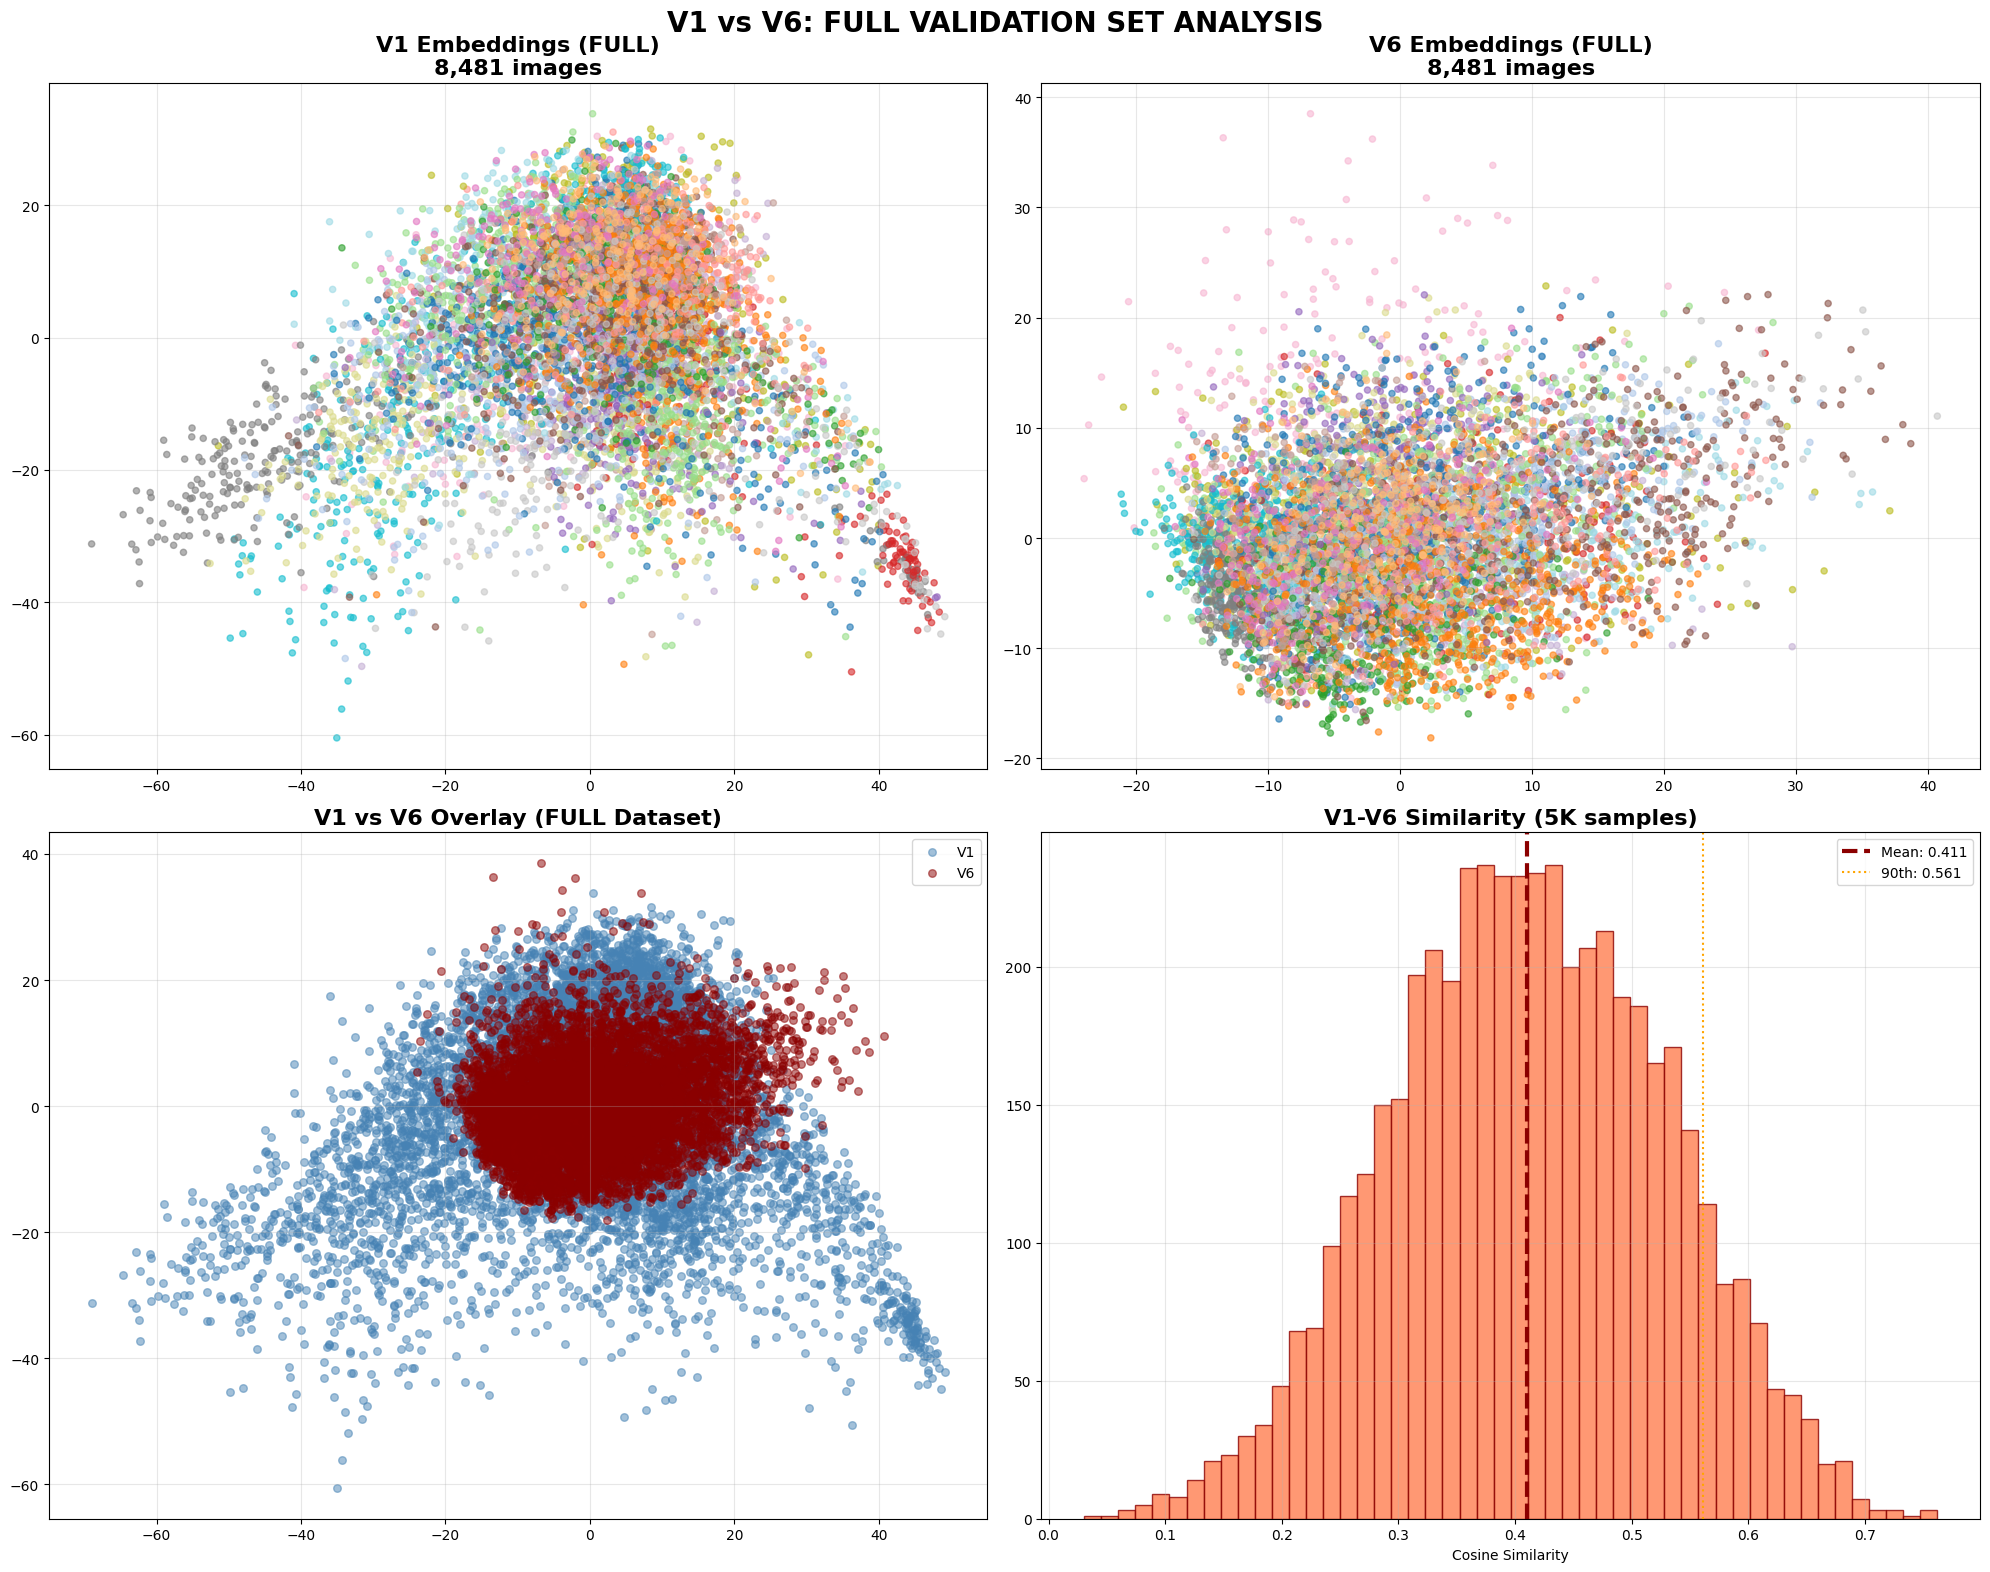


🎯 FULL VALIDATION RESULTS:
Total images: 8,481 (V1), 8,481 (V6)
Embedding dims: 153600
Similarity: 0.411 ± 0.117
High (>0.9): 0.0%
Medium (0.7-0.9): 0.3%
Low (<0.7): 99.7%
90th percentile: 0.561
10th percentile: 0.259
✅ Saved: v1_vs_v6_FULL_validation.png


In [ ]:
# ===========================
# V1 vs V6: FULL VALIDATION SET
# ===========================
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

print("🔍 Loading FULL validation set...")
metadata = pd.read_csv("/kaggle/input/k/adiithape/cnn-model-v3/outputs/metadata/curated_val_v6.csv")
val_df = metadata[metadata['split'] == 'val'].reset_index(drop=True)
print(f"✅ FULL validation: {len(val_df):,} images, {val_df['label'].nunique()} classes")


def extract_embeddings_safe(model, df):
    model.eval()
    embeddings = []
    labels = []
    transform = tf_val
    
    successful = 0
    pbar = tqdm(range(len(df)), desc="Extracting")
    
    for i in pbar:
        try:
            row = df.iloc[i]
            img_bgr = cv2.imread(row['filepath'])
            if img_bgr is None: continue
                
            x = transform(image=img_bgr)["image"].unsqueeze(0).to(DEVICE)
            
            with torch.no_grad():
                feats = model.forward_features(x)
                emb = feats[0].cpu().numpy().flatten()
            
            embeddings.append(emb)
            labels.append(row['label'])
            successful += 1
            
        except:
            continue
    
    print(f"✅ Processed {successful}/{len(df)} images")
    return np.array(embeddings), labels

# Extract FULL dataset
print("\n🔄 V1 FULL embeddings...")
emb_v1, labels_v1 = extract_embeddings_safe(model_v1, val_df)

print("🔄 V6 FULL embeddings...")
emb_v6, labels_v6 = extract_embeddings_safe(model_v6, val_df)

print(f"✅ FINAL shapes: V1 {emb_v1.shape}, V6 {emb_v6.shape}")

# Safe PCA (handles large datasets)
def safe_pca_full(X, n_components=2):
    print(f"🔄 PCA on {X.shape}...")
    
    # Truncate features for stability
    max_features = 5000
    X_trunc = X[:, :max_features]
    
    # Center
    X_mean = np.mean(X_trunc, axis=0)
    X_centered = X_trunc - X_mean
    
    # Incremental SVD (batch processing)
    batch_size = 1000
    all_projections = []
    
    for i in range(0, X.shape[0], batch_size):
        batch = X_centered[i:i+batch_size]
        if len(all_projections) == 0:
            # First batch: compute components
            U, S, Vt = np.linalg.svd(batch, full_matrices=False)
            components = Vt[:n_components]
        # Project batch
        proj = np.dot(batch, components.T)
        all_projections.append(proj)
    
    return np.vstack(all_projections)

# Project FULL dataset
emb_v1_2d = safe_pca_full(emb_v1)
emb_v6_2d = safe_pca_full(emb_v6)

# Colors
all_labels = list(set(labels_v1 + labels_v6))
label_colors = {label: i % 20 for i, label in enumerate(all_labels)}
colors_v1 = np.array([label_colors.get(l, 0) for l in labels_v1])
colors_v6 = np.array([label_colors.get(l, 0) for l in labels_v6])

# BIG 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# V1 full
scatter = axes[0,0].scatter(emb_v1_2d[:,0], emb_v1_2d[:,1], 
                           c=colors_v1, cmap='tab20', s=20, alpha=0.6)
axes[0,0].set_title(f'V1 Embeddings (FULL)\n{len(emb_v1):,} images', fontweight='bold', fontsize=16)
axes[0,0].grid(True, alpha=0.3)

# V6 full
scatter = axes[0,1].scatter(emb_v6_2d[:,0], emb_v6_2d[:,1], 
                           c=colors_v6, cmap='tab20', s=20, alpha=0.6)
axes[0,1].set_title(f'V6 Embeddings (FULL)\n{len(emb_v6):,} images', fontweight='bold', fontsize=16)
axes[0,1].grid(True, alpha=0.3)

# Overlay (density plot style)
axes[1,0].scatter(emb_v1_2d[:,0], emb_v1_2d[:,1], c='steelblue', s=30, alpha=0.5, label='V1')
axes[1,0].scatter(emb_v6_2d[:,0], emb_v6_2d[:,1], c='darkred', s=30, alpha=0.5, label='V6')
axes[1,0].set_title('V1 vs V6 Overlay (FULL Dataset)', fontweight='bold', fontsize=16)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# FULL similarity analysis
min_len = min(len(emb_v1), len(emb_v6))
sample_size = min(5000, min_len)  # 5K samples for robust stats
indices = np.random.choice(min_len, sample_size, replace=False)

print("🔄 Computing FULL similarity...")
cos_sim = []
for i in indices:
    emb1 = emb_v1[i, :5000]  # Truncate for speed
    emb2 = emb_v6[i, :5000]
    sim = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2) + 1e-8)
    cos_sim.append(sim)

axes[1,1].hist(cos_sim, bins=50, alpha=0.8, color='coral', edgecolor='darkred')
axes[1,1].axvline(np.mean(cos_sim), color='darkred', linestyle='--', linewidth=3, 
                 label=f'Mean: {np.mean(cos_sim):.3f}')
axes[1,1].axvline(np.percentile(cos_sim, 90), color='orange', linestyle=':', 
                 label=f'90th: {np.percentile(cos_sim, 90):.3f}')
axes[1,1].set_xlabel('Cosine Similarity')
axes[1,1].set_title('V1-V6 Similarity (5K samples)', fontweight='bold', fontsize=16)
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.suptitle('V1 vs V6: FULL VALIDATION SET ANALYSIS', fontsize=20, y=0.98, fontweight='bold')
plt.tight_layout()
plt.savefig('v1_vs_v6_FULL_validation.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Comprehensive stats
cos_sim = np.array(cos_sim)
print(f"\n🎯 FULL VALIDATION RESULTS:")
print(f"Total images: {len(emb_v1):,} (V1), {len(emb_v6):,} (V6)")
print(f"Embedding dims: {emb_v1.shape[1]}")
print(f"Similarity: {np.mean(cos_sim):.3f} ± {np.std(cos_sim):.3f}")
print(f"High (>0.9): {100*np.mean(cos_sim>0.9):.1f}%")
print(f"Medium (0.7-0.9): {100*np.mean((cos_sim>0.7)&(cos_sim<0.9)):.1f}%")
print(f"Low (<0.7): {100*np.mean(cos_sim<0.7):.1f}%")
print(f"90th percentile: {np.percentile(cos_sim, 90):.3f}")
print(f"10th percentile: {np.percentile(cos_sim, 10):.3f}")
print("✅ Saved: v1_vs_v6_FULL_validation.png")
